In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
_include_('curriculum_vqa')

from cvqa.curriculum import plotter, VQAInstanceDistribution2
from cvqa import trainers, datasets, viz

concept_dict = {
        'color': ['blue', 'brown', 'cyan', 'gray'],  # , 'green', 'purple', 'red', 'yellow'],
        'material': ['metal', 'rubber', 'plastic'],
        'shape': ['triangle', 'circle', 'square']
    }

# vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, prompt_types_filter=['retrieve_attribute'], d_img=24)
vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, d_img=24)

Img Encoder: Loss=0.000: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


In [3]:
# ds_temp = vqa_dist.sample_dataset(images=20, prompts_per_image=3)
# VQAInstanceDistribution2.to_debug_rep(ds_temp)

In [4]:
import random
import numpy as np
import torch

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

ds_train, ds_dev = datasets.Curriculum.from_samples(
    vqa_dist.sample_dataset(images=1000, prompts_per_image=5),
    vqa_dist.sample_dataset(images=100, prompts_per_image=5),
)

ds_train

Root: - 
Samples: 2891 (N_prompt=9, N_target=1)
Concepts: 0 
Classes: 0 
Prompt Vocab Tokens:43 
Answer Vocab Tokens:21 

In [5]:
trainer = trainers.VQATrainer(log_dir=None, progressbar='epochs')

def train_model(model, lr=1e-4, lr_decay_step_size=None, epochs=10, batch_size=32):
    
    tracker = None
#     tracker = traintracks.TrainTracker(root='traintracks/eval')
#     tracker.save_module(sys.modules['cvqa.models2'])
#     tracker.log_conf(model.args)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=0.1)
    
    train_loss, train_acc, dev_acc = trainer.train(
        model, ds_train, ds_dev, 
        optimizer, 
        optim_sched=scheduler,
        traintracker=tracker, num_epochs=epochs, batch_size=batch_size
    )
    
    return {
        'train_loss': train_loss, 
        'train_acc': train_acc, 
        'dev_acc': dev_acc
    }

[epoch=14, steps=1350, train_acc=0.99, dev_acc=0.99] loss: 0.052: 100%|██████████| 15/15 [00:20<00:00,  1.34s/it]


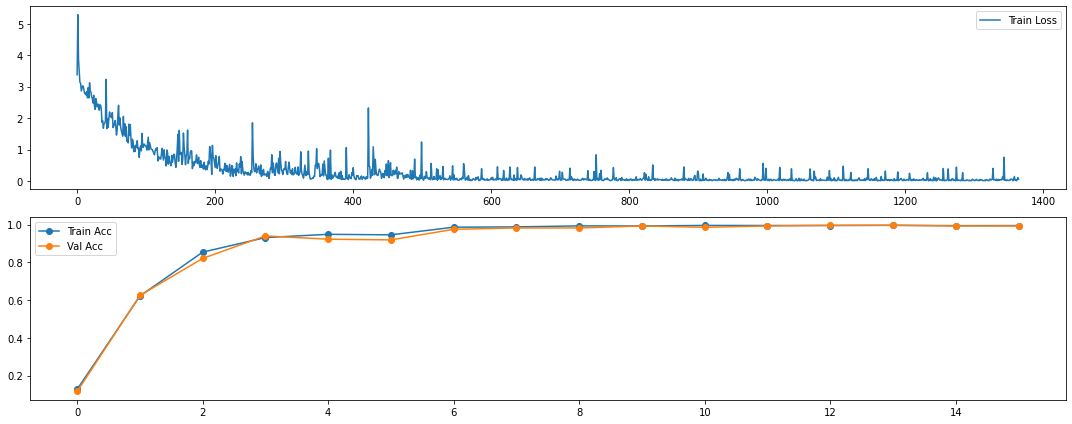

In [9]:
import numpy as np
import torch
from cvqa.model_dev import answer_model

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

args = answer_model.default_args()
args['d_a'] = 4
args['d_w'] = args['d_c'] = 24
args['d_o'] = 24
args['d_k'] = 8
args['encoder_layers'] = 2
args['encoder_ffn_dim'] = 32

model = answer_model.ParentModel(ds_train.vocab, ds_train.ans_vocab, args)

# print(trainer.evaluate(model, torch.utils.data.DataLoader(ds_train, batch_size=32)))

train_metrics = train_model(model, lr=3e-3, lr_decay_step_size=500, epochs=15, batch_size=32)

viz.plot_training(**train_metrics)

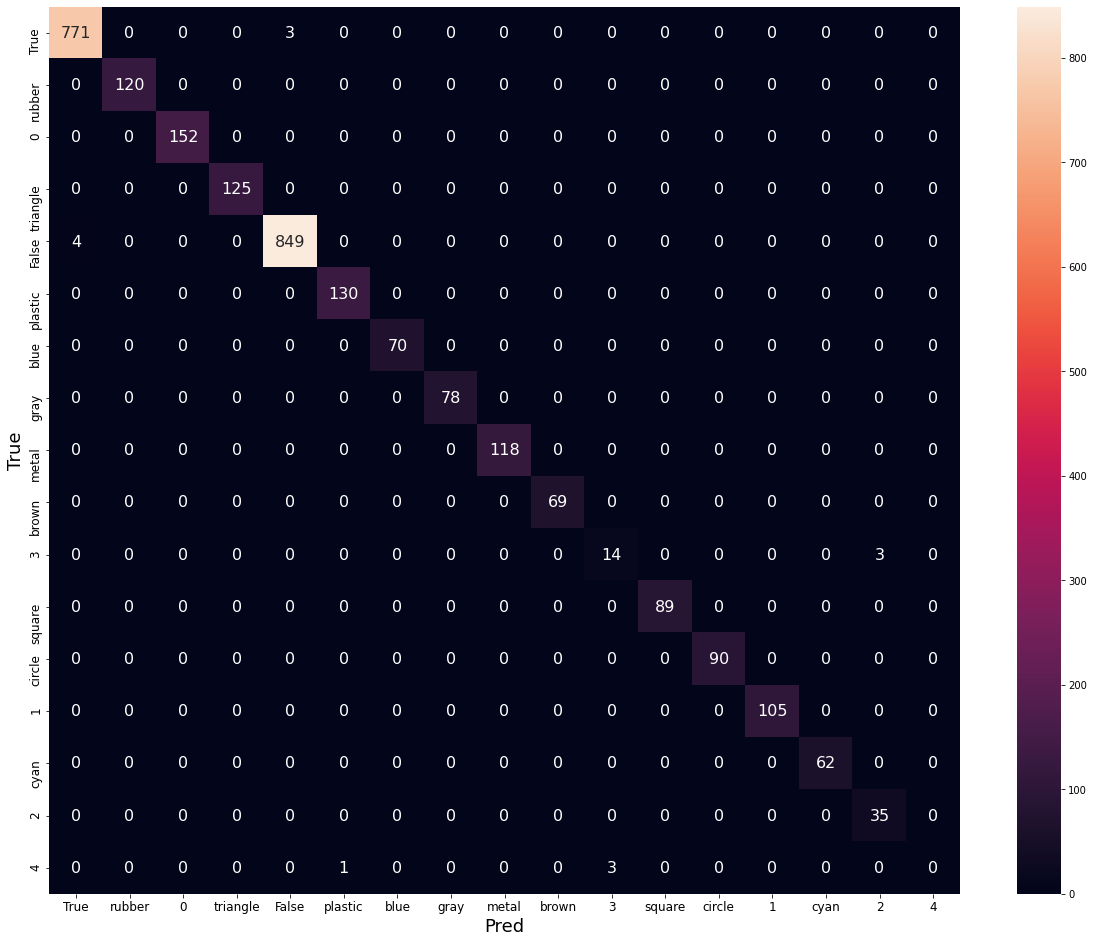

In [10]:
y_true, y_pred = trainer.get_predictions(model, ds_train)
viz.one_word_conf_mat(y_true, y_pred, ds_dev.ans_vocab)

In [8]:
import pandas as pd

y_true, y_pred = trainer.get_predictions(model, ds_dev)

questions = []
y_true_str = []
y_pred_str = []
for i, s in enumerate(ds_dev.samples):
    questions.append(s['prompt'])
    y_true_str.append(ds_train.ans_vocab.string(y_true[i]))
    y_pred_str.append(ds_train.ans_vocab.string(y_pred[i]))
    
    
res = pd.DataFrame({
    'question': questions,
    'y_true': y_true_str,
    'y_pred': y_pred_str
})

res[res['y_true'] != res['y_pred']]

,question,y_true,y_pred
59,Are there 3 metal circles ?,False,True
125,How many circles are there ?,4,3
188,Are there 4 rubber items ?,False,True


In [9]:
ds_train.samples[27]

{'viz_rep': {'objects': [{'location': [0.35, 0.89],
    'size': 0.06,
    'color': 'brown',
    'material': 'metal',
    'shape': 'square'},
   {'location': [0.4, 0.54],
    'size': 0.27,
    'color': 'blue',
    'material': 'metal',
    'shape': 'triangle'},
   {'location': [0.64, 0.31],
    'size': 0.06,
    'color': 'brown',
    'material': 'metal',
    'shape': 'square'},
   {'location': [0.4, 0.6],
    'size': 0.11,
    'color': 'brown',
    'material': 'rubber',
    'shape': 'circle'},
   {'location': [0.7, 0.15],
    'size': 0.06,
    'color': 'cyan',
    'material': 'rubber',
    'shape': 'circle'}],
  'encoded': tensor([[-2.0387,  0.4389, -3.1819, -0.2823,  2.7255,  2.8898,  0.7436, -2.1276,
            0.8425,  3.5908, -0.4337, -1.0403,  2.7715,  1.9260,  0.3778,  0.0172,
            0.4289,  0.8954,  0.1152,  0.3799,  0.8936,  0.0348,  0.3902,  0.9492],
          [-0.0923,  0.2472, -1.8920, -2.6586,  3.0308,  2.8755,  1.2025, -2.1766,
            1.9954, -1.5208,  1.8829,  0